<h1><center> Group Assignment: Bird Classifier  </center></h1>

In [2]:
# Import PyTorch and supporting libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from PIL import Image

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
import torch

if torch.backends.mps.is_available():
    print("MPS backend is available. Running on Apple GPU.")
else:
    print("MPS backend is not available. Running on CPU.")


MPS backend is available. Running on Apple GPU.


In [4]:
device = torch.device("mps")  # Use MPS for Apple Silicon
x = torch.tensor([1.0, 2.0, 3.0], device=device)
print("Tensor on MPS:", x)

Tensor on MPS: tensor([1., 2., 3.], device='mps:0')


In [5]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Load the CSV file
# train data
train_csv_path = "data/train_images.csv"
train_label_df = pd.read_csv(train_csv_path)

# test data
test_csv_path = "data/test_images_path.csv"  # Update this path
test_label_df = pd.read_csv(test_csv_path)
# Drop the 'id' column
test_label_df = test_label_df.drop(columns=['id'])


class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image paths and labels.
            root_dir (str): Directory containing all the images.
            transform (callable, optional): Transform to apply to the images.
        """
        self.data = pd.read_csv(csv_file)  # Read the CSV file
        self.transform = transform        # Image transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label
        img_path = "./data/train_images/"+self.data.iloc[idx, 0]  # Image file path
        label = self.data.iloc[idx, 1]

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [6]:
class TestDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image paths and labels.
            root_dir (str): Directory containing all the images.
            transform (callable, optional): Transform to apply to the images.
        """
        self.data = pd.read_csv(csv_file)  # Read the CSV file
        self.transform = transform        # Image transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label
        img_path = "./data/test_images/"+self.data.iloc[idx, 1]  # Image file path
        label = self.data.iloc[idx, 2]

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [7]:
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset

# pre-process the data
# Define a transformation pipeline with resizing
transform = transforms.Compose([
    transforms.Resize((320, 320)),  # Resize to slightly larger
    transforms.CenterCrop(299),    # Crop to 299x299
    transforms.RandomHorizontalFlip(p=0.5),      # Randomly flip images horizontally with a 50% probability
    transforms.RandomRotation(degrees=15),       # Randomly rotate images within 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

batch_size = 32
learning_rate = 0.0001
num_epochs = 10

# Try validation / train split
from sklearn.model_selection import train_test_split

# Instantiate the dataset
train_dataset = CustomDataset(csv_file=train_csv_path, transform=transform)
test_dataset = TestDataset(csv_file=test_csv_path, transform=transform)

# Get all indices
train_dataset_size = len(train_dataset)
indices = list(range(train_dataset_size))

# Split into train, validation, and test indices
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Create Subsets
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# Create DataLoaders
batch_size = 32
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False) # set batch size to 1 so that we check all 4000 images

# Check sizes
print(f"Train dataset size: {len(train_subset)}")
print(f"Validation dataset size: {len(val_subset)}")


Train dataset size: 3140
Validation dataset size: 786


In [8]:
# Access a batch of data
images, labels = next(iter(train_dataloader))
print("Batch of Images Shape:", images.shape)
print("Batch of Labels:", labels)

max_label = max(labels.max().item() for _, labels in train_dataloader)
print(f"Maximum label: {max_label}")

# Flatten all labels into a single tensor and compute unique classes
all_labels = []
for _, labels in train_dataloader:
    all_labels.extend(labels.numpy())  # Collect labels into a single list

num_classes = len(set(all_labels))  # Compute the number of unique classes
print(f"Number of classes: {num_classes}")

Batch of Images Shape: torch.Size([32, 3, 299, 299])
Batch of Labels: tensor([182,  24, 136, 182,  79,  64, 106, 158,  70,  53, 138,  34,  69, 184,
         27,  37,  94, 122, 139,  34,  28, 104, 173,  66,  79,  14, 115,  90,
        152,  99, 183,   2])
Maximum label: 200
Number of classes: 200


In [9]:
# Access a batch of data
images, labels = next(iter(val_dataloader))
print("Batch of Images Shape:", images.shape)
print("Batch of Labels:", labels)

max_label = max(labels.max().item() for _, labels in val_dataloader)
print(f"Maximum label: {max_label}")

# Flatten all labels into a single tensor and compute unique classes
all_labels = []
for _, labels in val_dataloader:
    all_labels.extend(labels.numpy())  # Collect labels into a single list

num_classes = len(set(all_labels))  # Compute the number of unique classes
print(f"Number of classes: {num_classes}")

Batch of Images Shape: torch.Size([32, 3, 299, 299])
Batch of Labels: tensor([149,  16, 189, 128,  74, 156,  22,  28, 140, 173,  12,  81,  82,  96,
         55,  89,  83,  44,   1, 120, 122,  55,  59,  77,  19, 178, 165, 152,
         10, 177,  24, 150])
Maximum label: 200
Number of classes: 188


In [10]:
# Iterate through the train DataLoader
for images, labels in train_dataloader:
    print(f"Batch of images: {images.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Batch of labels: {labels}")       # Should match the batch_size
    break

# Iterate through the test DataLoader
for images, labels in test_dataloader:
    print(f"\nBatch of images: {images.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Batch of labels: {labels}")       # Should match the batch_size
    break

Batch of images: torch.Size([32, 3, 299, 299])
Batch of labels: tensor([143,  85,  24,  57, 149,  76, 106,  97,  22,  92, 153, 115, 127,  18,
        198, 137, 103, 183, 181, 147,  76, 108, 173,  71,  94, 192, 117, 127,
         41,  14, 167,  70])

Batch of images: torch.Size([1, 3, 299, 299])
Batch of labels: tensor([1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


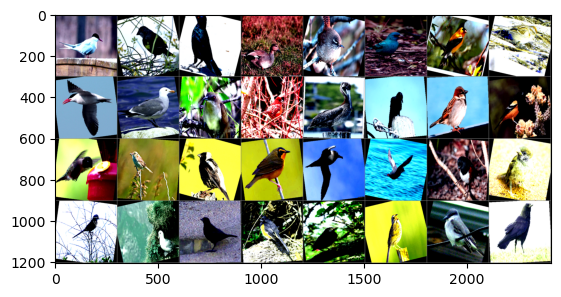

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))


In [12]:
#Step 2: Define a simple CNN model
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(16 * 64 * 64, num_classes)  # 16 channels * 64x64 image size
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x
    

# Load a pretrained ResNet model
net = models.inception_v3(pretrained=True)
net.to(device)

/Users/christinaperdue/anaconda3/envs/lab2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/christinaperdue/anaconda3/envs/lab2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /Users/christinaperdue/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
  9%|▉         | 9.80M/104M [00:00<00:08, 11.5MB/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [13]:
def train_and_evaluate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            # for training inception model v3
             # extract the output (logits)
            logits = outputs.logits
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # for training resnet18
            # loss = criterion(outputs, labels)
            # loss.backward()
            # optimizer.step()
            running_loss += loss.item()

        # Validation step
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        
        val_accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}, Val Accuracy: {val_accuracy}")
    return val_accuracy

In [ ]:
# from itertools import product

# # Define hyperparameter grid
# param_grid = {
#     'lr': [0.001, 0.01],
#     'batch_size': [16, 32],
#     'optimizer': ['SGD', 'Adam'],
#     'weight_decay': [0.0001, 0.001],
#     'momentum': [0.8, 0.9]  # Used only for SGD
# }

# # Iterate through all combinations
# best_params = None
# best_accuracy = 0
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# for lr, batch_size, optimizer_name, weight_decay, momentum in product(
#     param_grid['lr'], param_grid['batch_size'], param_grid['optimizer'], 
#     param_grid['weight_decay'], param_grid['momentum']
# ):
#     print(f"Testing combination: LR={lr}, Batch Size={batch_size}, Optimizer={optimizer_name}, WD={weight_decay}, Momentum={momentum}")

    
#     # Set optimizer
#     if optimizer_name == 'SGD':
#         optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
#     elif optimizer_name == 'Adam':
#         optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    
#     # Loss function
#     criterion = nn.CrossEntropyLoss()
    
#     # Train and evaluate
#     accuracy = train_and_evaluate(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=5)
    
#     # Save best params
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_params = {
#             'lr': lr,
#             'batch_size': batch_size,
#             'optimizer': optimizer_name,
#             'weight_decay': weight_decay,
#             'momentum': momentum
#         }

# print(f"Best Hyperparameters: {best_params}, Accuracy: {best_accuracy}")

In [14]:
print(net)

# Define a loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # would adding momentum do anything?
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.001)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
accuracy = train_and_evaluate(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)

In [ ]:
# NOTE: Different way to train the model but we use the train_and_evaluate function

# for epoch in range(num_epochs):
#     net.train()  # Set model to training mode
#     running_loss = 0.0
#     total = 0  # Initialize total for this epoch
#     correct = 0  # Initialize correct for this epoch

#     for images, labels in train_dataloader:
#         # Move data to device
#         images, labels = images.to(device), labels.to(device)

#         # Forward pass
#         outputs = net(images)
#         loss = criterion(outputs, labels)  # Adjust labels if 1-indexed

#         # Zero the parameter gradients
#         optimizer.zero_grad()
        
#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         # Accumulate loss for display
#         running_loss += loss.item()
#         total += labels.size(0)
#         batch_correct = (torch.argmax(outputs, 1) == labels).sum().item()  # Adjust for 1-indexed labels
#         correct += batch_correct
    
#     # Display epoch results
#     epoch_loss = running_loss / len(train_dataloader)
#     epoch_accuracy = correct / total * 100
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


In [ ]:
# Make a prediction on the test set

net.eval()  # Set model to evaluation mode

predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:  # Assuming dataset includes image paths
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = net(images)
        
        # Get predictions (no need to subtract or add indices unless necessary)
        _, preds = torch.max(outputs, 1)
        
        # Append predictions to the list
        predictions.extend(preds.cpu().numpy())  # Convert to list and extend the predictions list
        #predictions.append((image, preds.item()))
        
        # Append original labels for analysis
        all_labels.extend(labels.cpu().tolist())  # Convert labels to list and extend

        

In [52]:
torch.save(net.state_dict(), "christinaperdue_net.pth")

In [ ]:
print(all_labels) # Only to see what is inside - not needed

# Save the predictions to a CSV file
df2 = pd.DataFrame(predictions, columns=['label'])
df2.index += 1  # Shift the index to start at 1
df2.to_csv("predictions.csv", index=True, index_label='id')
print(df2.head())

[38, 33, 136, 42, 178, 12, 49, 17, 17, 25, 95, 82, 26, 111, 170, 189, 121, 138, 9, 187, 101, 16, 103, 55, 158, 95, 123, 139, 63, 35, 128, 78, 3, 85, 119, 63, 53, 48, 4, 54, 172, 132, 124, 127, 28, 15, 63, 110, 100, 49, 46, 88, 102, 98, 15, 57, 104, 39, 103, 14, 30, 72, 107, 73, 14, 42, 91, 1, 180, 87, 28, 40, 149, 65, 30, 8, 129, 63, 158, 48, 23, 81, 166, 52, 15, 100, 98, 59, 133, 6, 39, 21, 10, 13, 29, 9, 86, 105, 120, 161, 91, 62, 33, 22, 31, 173, 83, 38, 113, 33, 12, 127, 175, 37, 15, 168, 68, 64, 75, 156, 25, 36, 182, 102, 194, 37, 108, 20, 43, 74, 57, 38, 63, 45, 125, 4, 35, 100, 113, 131, 37, 27, 42, 3, 9, 31, 102, 77, 117, 106, 131, 61, 135, 81, 115, 115, 49, 149, 15, 178, 87, 56, 155, 120, 24, 76, 191, 21, 110, 196, 56, 30, 113, 14, 82, 73, 59, 79, 108, 26, 169, 91, 61, 95, 116, 77, 141, 38, 55, 83, 101, 94, 22, 140, 93, 26, 56, 26, 142, 159, 45, 157, 165, 34, 199, 8, 111, 156, 74, 47, 104, 34, 86, 62, 77, 83, 7, 25, 58, 3, 53, 16, 77, 26, 60, 44, 70, 45, 80, 109, 20, 14, 8, 36

/Users/christinaperdue/anaconda3/envs/lab2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/christinaperdue/anaconda3/envs/lab2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/christinaperdue/anaconda3/envs/lab2/lib/python3.12/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


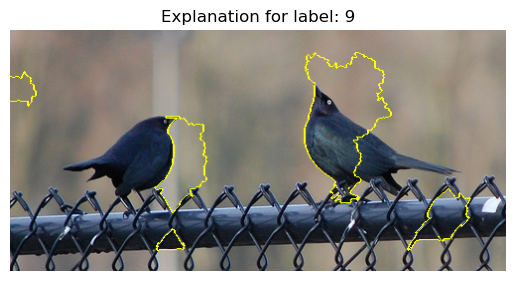

In [ ]:
#LIME Setup

# Import necessary libraries
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Step 1: Load the saved model
# model = models.resnet18(pretrained=False)
# model.load_state_dict(torch.load('christinaperdue_net.pth', map_location=torch.device('cpu')))

model = models.inception_v3(pretrained=False)
model.load_state_dict(torch.load('christinaperdue_colab_inception_v3_transformations_net.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

# Step 2: Define the image preprocessing pipeline
preprocess = transforms.Compose([
    # select this for resnet
    # transforms.Resize((224, 224)),  # Resize to match ResNet input size
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization

    # select this for inception
    transforms.Resize((320, 320)),  # Resize to slightly larger
    transforms.CenterCrop(299),    # Crop to 299x299
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to [-1, 1]
])



# Step 3: Load and preprocess the image
#431
test_image_path = 'data/test_images/test_images/493.jpg'
image = Image.open(test_image_path).convert('RGB')
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

# Step 4: Define the prediction function
def predict_function(images):
    """
    LIME expects a NumPy array as input.
    This function converts images back to PyTorch tensors, predicts, and outputs probabilities.
    """
    images = torch.tensor(images).permute(0, 3, 1, 2)  # Convert to (batch, channels, height, width)
    images = images.float() / 255  # Scale pixel values to [0, 1]
    
    # Normalize images like in preprocessing
    for i in range(images.shape[0]):
        images[i] = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(images[i])
    
    with torch.no_grad():
        outputs = model(images)  # Get logits
        probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Convert to probabilities
    return probabilities.numpy()

# Step 5: Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Step 6: Generate explanation
explanation = explainer.explain_instance(
    np.array(image),  # Pass the image as a NumPy array
    predict_function,  # The prediction function
    top_labels=5,  # Number of top labels to explain
    hide_color=0,  # Hide regions with zero color
    num_samples=1000  # Number of perturbed samples
)

# Step 7: Visualize the explanation
from matplotlib import pyplot as plt

# Choose the label to visualize
label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Display the explanation
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"Explanation for label: {label}")
plt.axis('off')
plt.show()